# (1) Preprocessing Dataset

Make sure dataset file are in correct location.
run preprocess.py

In [31]:
from data.LDA import preprocess_text
from train.saving import save_model_results
from model.mf import MF_Bias, LDANet
from model.utility import RMSELoss

import pickle
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import gc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from train.saving import save_model_results
from skorch import NeuralNetRegressor

In [32]:
subsets = {
        "reviews_Toys_and_Games_5.json",
        "reviews_Apps_for_Android_5.json",
        "reviews_Health_and_Personal_Care_5.json",
    }
pth = os.getcwd()[:-4]
NUM_TOPICS = 10
#preprocess_text(dataset=subsets, pth=pth, n_topics=NUM_TOPICS)
print(pth)

/Users/jb/Documents/GitHub/Intro ML (Nick Pang) Repository/rl-recommender


In [33]:
TG5_df = pd.read_json(os.path.join(pth, "datasets", "raw","reviews_Toys_and_Games_5.json"), lines=True)
AA5_df = pd.read_json(os.path.join(pth, "datasets", "raw", "reviews_Apps_for_Android_5.json"), lines=True)
HPC_df = pd.read_json(os.path.join(pth, "datasets", "raw", "reviews_Health_and_Personal_Care_5.json"), lines=True)

df = pd.concat([TG5_df, AA5_df, HPC_df], axis=0)
del TG5_df, AA5_df, HPC_df

# Keep essentials only
df = df[['reviewerID', 'asin', 'overall']]
print(df)

            reviewerID        asin  overall
0       A1VXOAVRGKGEAK  0439893577        5
1        A8R62G708TSCM  0439893577        4
2       A21KH420DK0ICA  0439893577        5
3        AR29QK6HPFYZ4  0439893577        5
4        ACCH8EOML6FN5  0439893577        4
...                ...         ...      ...
346350  A11J1FHCK5U06J  B00LJBMCKK        5
346351   AFVKI7BCS3FSX  B00LJBMCKK        5
346352  A1Y3FEUELH3FTI  B00LJBMCKK        5
346353  A11LC938XF35XN  B00LJBMCKK        5
346354  A2I8KUDXTC9WYI  B00LJBMCKK        5

[1266889 rows x 3 columns]


In [34]:
# Map values
user_dict = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "user_mappings.csv"))
item_dict = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "item_mappings.csv"))
user_dict = dict(zip(user_dict.iloc[:, 1], user_dict.index))
item_dict = dict(zip(item_dict.iloc[:, 1], item_dict.index))

df['reviewerID'] = df['reviewerID'].map(user_dict).fillna(df['reviewerID'])
df['asin'] = df['asin'].map(item_dict).fillna(df['asin'])

df[['reviewerID', 'asin']] = df[['reviewerID', 'asin']].astype(int)
df['overall'] = df['overall'].astype(float)

df = df.sort_values(by=['reviewerID', 'asin'], ignore_index=True)

print(df)

         reviewerID   asin  overall
0                 0      0      3.0
1                 0   1681      5.0
2                 0   2388      1.0
3                 0   3708      2.0
4                 0   5357      5.0
...             ...    ...      ...
1266884      139812  43360      5.0
1266885      139812  43429      5.0
1266886      139812  43462      5.0
1266887      139812  43582      5.0
1266888      139812  43646      5.0

[1266889 rows x 3 columns]


In [35]:
m = df['overall'].mean()
np.savez_compressed(os.path.join(pth, "datasets", "processed", "Subset_5core_PreprocessLDA.npz"),
                    x = df[['reviewerID', 'asin']],
                    y = df['overall'],
                    u_size = len(user_dict),
                    i_size = len(item_dict),
                    m = m)

# (2) Create Model

This model doesn't use internal LDA YET!

### I wanted to test running on Apple Silicon Chips

In [36]:
device = torch.device('mps' if torch.has_mps else 'cpu')
f_type = torch.float32 if device.type == 'mps' else torch.float64
print(f"device_type: {device}")
print(f"float_type: {f_type}")


max_v = max(df['reviewerID'].max(), df['asin'].max())
min_v = max(df['reviewerID'].min(), df['asin'].min())
print(f"max value: {max_v}\nmin value: {min_v}")

if 0 <= min_v <= 255 and 0 <= max_v <= 255:
    int_type = torch.uint8
elif -128 <= min_v <= 127 and -128 <= max_v <= 127:
    int_type = torch.int8
elif -32768 <= min_v <= 32767 and -32768 <= max_v <= 32767:
    int_type = torch.int16
elif -2147483648 <= min_v <= 2147483647 and -2147483648 <= max_v <= 2147483647:
    int_type = torch.int32
else:
    int_type = torch.int64
print(f"int_type: {int_type}")

device_type: mps
float_type: torch.float32
max value: 139812
min value: 0
int_type: torch.int32


In [37]:
BATCH_SIZE = 256
LEARNING_RATE = 0.0005
EPOCHS = 10
DECAY = 1e-3
DROPOUT = 0.4

In [38]:
gc.collect()

data = np.load(os.path.join(pth, "datasets", "processed", "Subset_5core_PreprocessLDA.npz"))
x = data['x']
y = data['y']
U_size = data['u_size']
I_size = data['i_size']
G_b = data['m']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

x_train, x_test = torch.tensor(x_train, dtype = int_type).to(device), torch.tensor(x_test, dtype = int_type).to(device) #Int because Embeddings layer
y_train, y_test = torch.tensor(y_train, dtype = f_type).to(device), torch.tensor(y_test, dtype = f_type).to(device)

loss_fn = RMSELoss()
optimizer = Adam

### I am adding the class here only so I append **.to(*device*)** for each tensor

In [39]:
## nn.Embedding initialized to random -1 to 1

class MF(nn.Module):
    def __init__(self, n_users, n_items, K, dropout=0):
        super().__init__()
        self.user_m = nn.Embedding(
            n_users, K, dtype=f_type
        ).to(device)  # can include option sparse = True for memory
        self.item_m = nn.Embedding(n_items, K, dtype=f_type).to(device)
        self.drop_u = nn.Dropout(dropout)
        self.drop_i = nn.Dropout(dropout)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        user_embeds = self.drop_u(self.user_m(user_ids))
        item_embeds = self.drop_i(self.item_m(item_ids))
        prod = user_embeds * item_embeds

        out = torch.sum(prod, 1)

        return out


# Matrix factorization with user/item biases
class MF_Bias(MF):
    def __init__(self, n_users, n_items, K, G_b, dropout=0):
        super().__init__(n_users, n_items, K, dropout)
        
        self.user_b = nn.Embedding(n_users, 1, dtype=f_type).to(device)
        self.item_b = nn.Embedding(n_items, 1, dtype=f_type).to(device)
        nn.init.zeros_(self.user_b.weight)
        nn.init.zeros_(self.item_b.weight)

        self.G_b = torch.from_numpy(G_b)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]
        out = super().forward(x)

        user_biases = self.user_b(user_ids).squeeze()
        item_biases = self.item_b(item_ids).squeeze()

        out += user_biases + item_biases + self.G_b

        return out

In [40]:
model = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)

In [41]:
# Since nn.Embedding initialized to random -1 to 1.
# Creating a mapping from row -> -1 to 1 

def row_mapping(l: list):
    min_v = float("inf")
    max_v = -float("inf")
    
    for v in l:
        if v > max_v:
            max_v = v
        if v < min_v:
            min_v = v
    
    return [((2 * (x - min_v)) / (max_v - min_v)) - 1 for x in l]

# example
print(row_mapping([
    0.0063068993260669,
    0.0063068993278832,
    0.0063068993273011,
    0.0063068993291702,
    0.0063068993316196,
    0.0063068993263096,
    0.0063068993281883,
    0.0063068993275349,
    0.3462632596023473,
    0.6032815457735784]))

[-1.0, -0.999999999993915, -0.9999999999958652, -0.9999999999896032, -0.9999999999813972, -0.9999999999991869, -0.9999999999928928, -0.9999999999950818, 0.13893064738778915, 1.0]


In [42]:
user_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "user_topics.csv"))
for idx,row  in user_map.iterrows():
    row = row[1:] # to remove 'User_ID' from row
    row = row.tolist()
    row = row_mapping(row)
    model.user_m.weight.data[idx] = torch.tensor(row, dtype=f_type).to(device)

item_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "item_topics.csv"))
for idx,row  in item_map.iterrows():
    row = row[1:] # to remove 'Item_ID' from row
    row = row.tolist()
    row = row_mapping(row)
    model.item_m.weight.data[idx] = torch.tensor(row, dtype=f_type).to(device)

# (3) Run Model

In [43]:
regressor = NeuralNetRegressor(
    model,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)
gc.collect()

8

### Borrowed from *save_model_results()*

In [44]:
results = regressor.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"User-Item-Model_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"User-Item-Model_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        2.1511        1.2392  70.1869
      2        1.2132        1.2020  69.0139
      3        1.1711        1.1792  65.5091
      4        1.1421        1.1640  65.7651
      5        1.1192        1.1528  65.6062
      6        1.1002        1.1444  65.5473
      7        1.0840        1.1378  65.6965
      8        1.0700        1.1327  65.1169
      9        1.0577        1.1287  64.9884
     10        1.0469        1.1256  66.0431


### Another Model without setting the weights

In [45]:
model_2 = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)

In [46]:
regressor_2 = NeuralNetRegressor(
    model_2,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)
gc.collect()

0

In [47]:
results_2 = regressor_2.fit(x_train, y_train)
history_2 = results.history

tr_losses_2 = [i['train_loss'] for i in history_2]
t_losses_2 = [i['valid_loss'] for i in history_2]

with open(os.path.join(pth, "results", f"No-Adjustments-Model_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model_2, f)

np.savez_compressed(os.path.join(pth, "results", f"No-Adjustments-Model_{device}_{f_type}.npz"),
                    tr_loss = tr_losses_2,
                    t_loss = t_losses_2)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        2.0770        1.2603  64.9237
      2        1.2367        1.1989  64.9960
      3        1.1697        1.1795  67.4094
      4        1.1422        1.1652  65.0346
      5        1.1199        1.1543  64.4534
      6        1.1011        1.1457  65.3672
      7        1.0848        1.1391  65.5481
      8        1.0708        1.1339  65.7681
      9        1.0584        1.1298  65.7612
     10        1.0475        1.1266  65.4709


### Only Preprocessed Users & Only Items

In [48]:
model_users = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)
model_items = MF_Bias(U_size, I_size, NUM_TOPICS, G_b, DROPOUT)

In [49]:
user_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "user_topics.csv"))
for idx,row  in user_map.iterrows():
    row = row[1:] # to remove 'User_ID' from row
    row = row.tolist()
    row = row_mapping(row)
    model_users.user_m.weight.data[idx] = torch.tensor(row, dtype=f_type).to(device)

item_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "item_topics.csv"))
for idx,row  in item_map.iterrows():
    row = row[1:] # to remove 'Item_ID' from row
    row = row.tolist()
    row = row_mapping(row)
    model_items.item_m.weight.data[idx] = torch.tensor(row, dtype=f_type).to(device)

In [50]:
regressor_users = NeuralNetRegressor(
    model_users,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)
regressor_items = NeuralNetRegressor(
    model_items,
    criterion = loss_fn,
    optimizer = optimizer,
    optimizer__param_groups = [
        ('user_m.weight', {'weight_decay': DECAY}),
        ('item_m.weight', {'weight_decay': DECAY})
    ],
    optimizer__lr = LEARNING_RATE,
    batch_size = BATCH_SIZE,
    max_epochs = EPOCHS
)

In [51]:
"""
results = regressor_users.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"Users-Only-Model_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"Users-Only-Model_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)
"""

'\nresults = regressor_users.fit(x_train, y_train)\nhistory = results.history\n\ntr_losses = [i[\'train_loss\'] for i in history]\nt_losses = [i[\'valid_loss\'] for i in history]\n\nwith open(os.path.join(pth, "results", f"Users-Only-Model_{device}_{f_type}.pkl"), \'wb\') as f:\n    pickle.dump(model, f)\n\nnp.savez_compressed(os.path.join(pth, "results", f"Users-Only-Model_{device}_{f_type}.npz"),\n                    tr_loss = tr_losses,\n                    t_loss = t_losses)\n'

In [52]:
"""
results = regressor_items.fit(x_train, y_train)
history = results.history

tr_losses = [i['train_loss'] for i in history]
t_losses = [i['valid_loss'] for i in history]

with open(os.path.join(pth, "results", f"Items-Only-Model_{device}_{f_type}.pkl"), 'wb') as f:
    pickle.dump(model, f)

np.savez_compressed(os.path.join(pth, "results", f"Items-Only-Model_{device}_{f_type}.npz"),
                    tr_loss = tr_losses,
                    t_loss = t_losses)
"""

'\nresults = regressor_items.fit(x_train, y_train)\nhistory = results.history\n\ntr_losses = [i[\'train_loss\'] for i in history]\nt_losses = [i[\'valid_loss\'] for i in history]\n\nwith open(os.path.join(pth, "results", f"Items-Only-Model_{device}_{f_type}.pkl"), \'wb\') as f:\n    pickle.dump(model, f)\n\nnp.savez_compressed(os.path.join(pth, "results", f"Items-Only-Model_{device}_{f_type}.npz"),\n                    tr_loss = tr_losses,\n                    t_loss = t_losses)\n'

# (4) Graphs

In [53]:
gc.collect()

0

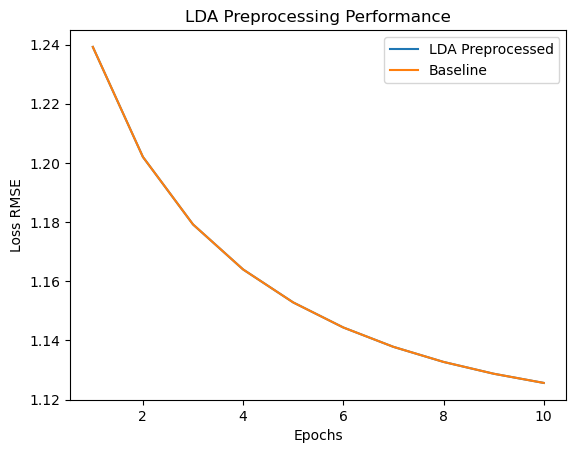

In [54]:
import matplotlib.pyplot as plt
p = np.load(os.path.join(pth, "results", f"User-Item-Model_{device}_{f_type}.npz"))
not_p = np.load(os.path.join(pth, "results", f"No-Adjustments-Model_{device}_{f_type}.npz"))
"""
u = np.load(os.path.join(pth, "results", f"Users-Only-Model_{device}_{f_type}.npz"))
i = np.load(os.path.join(pth, "results", f"Items-Only-Model_{device}_{f_type}.npz"))
"""

plt.plot([i+1 for i in range(EPOCHS)], p['t_loss'], label='LDA Preprocessed')
plt.plot([i+1 for i in range(EPOCHS)], not_p['t_loss'], label='Baseline')
"""
plt.plot([i+1 for i in range(EPOCHS)], u['t_loss'], label='Only Users')
plt.plot([i+1 for i in range(EPOCHS)], i['t_loss'], label='Only Items')
"""
plt.xlabel('Epochs')
plt.ylabel('Loss RMSE')
plt.title('LDA Preprocessing Performance')
plt.legend()
plt.show()

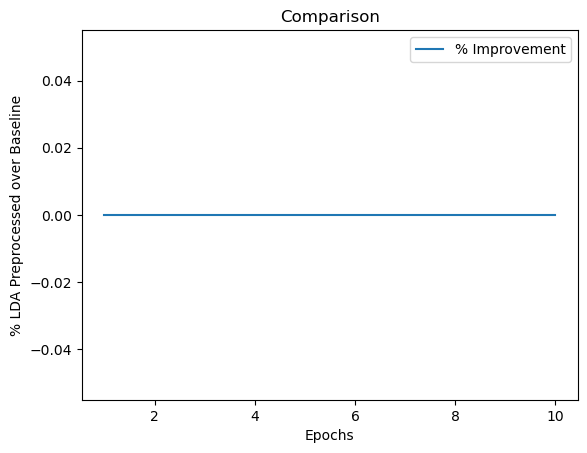

In [55]:
factor = list()
for i in range(len(p['t_loss'])):
    f = (100 *(float(not_p['t_loss'][i]) / float(p['t_loss'][i]))) - 100
    factor.append(f)

plt.plot([i+1 for i in range(EPOCHS)], factor, label='% Improvement')
plt.xlabel('Epochs')
plt.ylabel('% LDA Preprocessed over Baseline')
plt.title('Comparison')
plt.legend()
plt.show()

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the initial values of the model
user_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "user_topics.csv"))
item_map = pd.read_csv(os.path.join(pth, "datasets", "processed", "lda", "item_topics.csv"))

initial_user_embeddings = np.zeros((len(user_map), 5))
initial_item_embeddings = np.zeros((len(item_map), 5))

for idx,row  in user_map.iterrows():
    row = row[1:]
    row = row.tolist()
    row = row_mapping(row)
    initial_user_embeddings[idx] = row

for idx,row  in item_map.iterrows():
    row = row[1:]
    row = row.tolist()
    row = row_mapping(row)
    initial_item_embeddings[idx] = row
    
# Get final values from model
final_user_embeddings = None
final_item_embeddings = None

with open(os.path.join(pth, "results", f"User-Item-Model_{device}_{f_type}.pkl"), 'rb') as f:
    model = pickle.load(f)
    final_user_embeddings = model.user_m.weight.cpu().detach().numpy()
    final_item_embeddings = model.item_m.weight.cpu().detach().numpy()
    
print(f"initial user: {initial_user_embeddings.shape}")
print(f"initial item: {initial_item_embeddings.shape}")
print(f"final user: {final_user_embeddings.shape}")
print(f"final item: {final_item_embeddings.shape}")

initial user: (139813, 5)
initial item: (43667, 5)
final user: (139813, 5)
final item: (43667, 5)


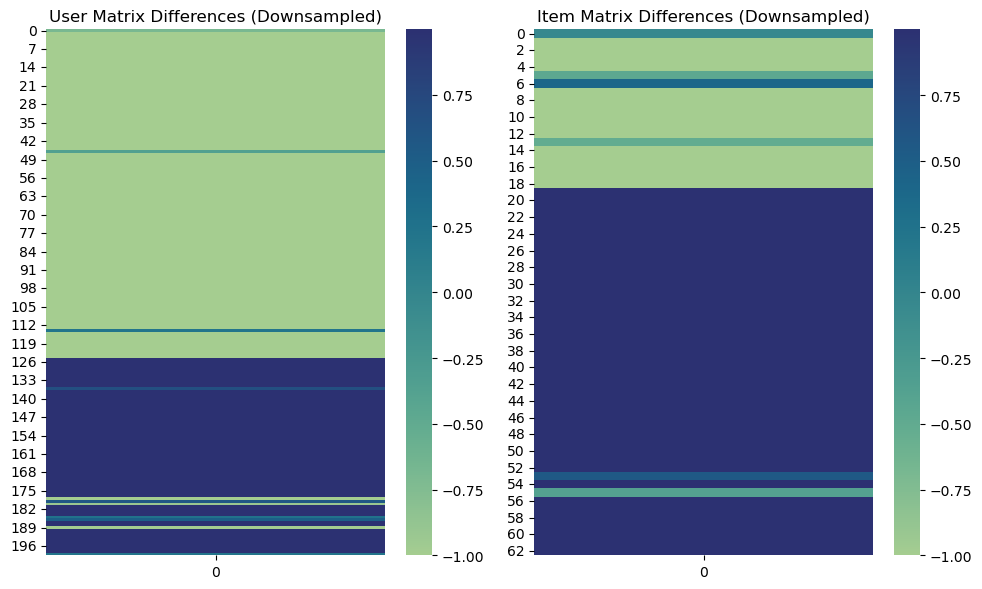

In [73]:
user_difference = final_user_embeddings - initial_user_embeddings
item_difference = final_item_embeddings - initial_item_embeddings

# Create heatmaps for user and item matrices
downsample_factor = 700  # Adjust the downsampling factor as needed
downsampled_user = user_difference[::downsample_factor, ::downsample_factor]
downsampled_item = item_difference[::downsample_factor, ::downsample_factor]

# Create heatmaps for downsampled user and item matrices
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.heatmap(downsampled_user, cmap="crest")
plt.title('User Matrix Differences (Downsampled)')

plt.subplot(1, 2, 2)
sns.heatmap(downsampled_item, cmap="crest")
plt.title('Item Matrix Differences (Downsampled)')

plt.tight_layout()
plt.show()